## Should This Loan Be Approved or Denied?

Dataset Source: https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied

#### Install Auto-Sklearn

In [1]:
%pip install -U matplotlib
%pip install -U numpy
%pip install auto-sklearn seaborn sklearn imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Import Necessary Libraries

In [2]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import autosklearn
from autosklearn.classification import AutoSklearnClassifier as ASC

#### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Show Library Versions

In [4]:
n = 18

print(f"Language/Library".rjust(n-2), '|', 'Version')
print('-' * (n-2), '|', '--------')
print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Sklearn :".rjust(n), sklearn.__version__)
print("Auto-Sklearn :".rjust(n), autosklearn.__version__)
print("Imblearn :".rjust(n), imblearn.__version__)
print("Seaborn :".rjust(n), sns.__version__)

Language/Library | Version
---------------- | --------
          Python : 3.10.1
           NumPy : 1.24.3
          Pandas : 1.5.3
         Sklearn : 0.24.2
    Auto-Sklearn : 0.15.0
        Imblearn : 0.8.1
         Seaborn : 0.12.2


### Initial Data Preprocessing

#### Ingest Dataset

In [5]:
col_names = ["id",
             "name",
             "city",
             "state",
             "zip",
             "bank",
             "bank_state",
             "naics",
             "approval_date",
             "approval_fy",
             "term",
             "num_of_emp",
             "new_exist",
             "created_job",
             "retained_job",
             "franchise_code",
             "urban_rural",
             "rev_line_cr",
             "low_doc",
             "charge_off_date",
             "disbursement_date",
             "disbursement_gross",
             "balance_gross",
             "mis_status",
             "charged_off_amt",
             "gr_appv",
             "sba_approval"
             ]

dtypes = {"id": np.int64,
          "name": str,
          "city": str,
          "state": str,
          "zip": np.uint16,
          "bank": str,
          "bank_state": str,
          "naics": str,
          "approval_date": str,
          "approval_fy": str,
          "term": np.uint16,
          "num_of_emp": np.uint16,
          "new_exist": np.float32,
          "created_job": np.uint32,
          "retained_job": np.uint32,
          "franchise_code": np.uint64,
          "urban_rural": str,
          "rev_line_cr": str,
          "low_doc": str,
          "charge_off_date": str,
          "disbursement_date": str,
          "disbursement_gross": str,
          "balance_gross": str,
          "mis_status": str,
          "charged_off_amt": str,
          "gr_appv": str,
          "sba_approval": str
              }

data = pd.read_csv("/content/drive/MyDrive/Home Loan Approval/SBAnational.csv",
                   names=col_names,
                   dtype=dtypes,
                   engine='c',
                   header=0)

# Remove Unnecessary Features
data = data.drop(axis=0,
                 columns=
                 [
                     'id',
                     'name',
                     'city',
                     'zip',
                     'bank',
                     'bank_state',
                     'approval_date',
                     'charge_off_date',
                     'disbursement_date'
                     ]
                 )

data.head()

,state,naics,approval_fy,term,num_of_emp,new_exist,created_job,retained_job,franchise_code,urban_rural,rev_line_cr,low_doc,disbursement_gross,balance_gross,mis_status,charged_off_amt,gr_appv,sba_approval
0,IN,451120,1997,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,IN,722410,1997,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,IN,621210,1997,180,7,1.0,0,0,1,0,N,N,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,OK,0,1997,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,FL,0,1997,240,14,1.0,7,7,1,0,N,N,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


#### Clean up Features

In [6]:
cols_to_remove_dollar_sign = [
    'disbursement_gross',
    'balance_gross',
    'gr_appv',
    'charged_off_amt',
    'sba_approval'
    ]

def remove_dollar_signs(df: pd.DataFrame,
                        feature_name: str) -> None:

    """
    This function takes a dataframe and feature as inputs
    and returns (as the output) that DataFrame with the
    following updates made to the feature:
        - all leading and trailing spaces are removed,
        - all dollar signs & commas are removed, &
        - converts the feature dtype to float32.
    """

    assert feature_name not in enumerate(df.columns), \
        "The remove_dollar_signs function can only " + \
        "handle features that are apart of the dataframe"

    df[feature_name] = data['sba_approval']\
        .apply(lambda x: x.strip())\
        .apply(lambda x: x.replace('$', ''))\
        .apply(lambda x: x.replace(',', ''))\
        .astype(np.float32)

for feat in cols_to_remove_dollar_sign:
    remove_dollar_signs(data, feat)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               899150 non-null  object 
 1   naics               899164 non-null  object 
 2   approval_fy         899164 non-null  object 
 3   term                899164 non-null  uint16 
 4   num_of_emp          899164 non-null  uint16 
 5   new_exist           899028 non-null  float32
 6   created_job         899164 non-null  uint32 
 7   retained_job        899164 non-null  uint32 
 8   franchise_code      899164 non-null  uint64 
 9   urban_rural         899164 non-null  object 
 10  rev_line_cr         894636 non-null  object 
 11  low_doc             896582 non-null  object 
 12  disbursement_gross  899164 non-null  float32
 13  balance_gross       899164 non-null  float32
 14  mis_status          897167 non-null  object 
 15  charged_off_amt     899164 non-nul

#### More Dataset Preprocessing

In [7]:
"""
When dropping any sample with any missing values,
it nets a loss of about 9,200 samples out of a
dataset with over 899,000 samples.
"""
data = data.dropna(how='any').reset_index(drop=True)

## Return only the first 2 characters in NAICS feature
data['naics'] = data['naics'].apply(lambda x: x[:2])\
    .astype(np.uint8)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889925 entries, 0 to 889924
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               889925 non-null  object 
 1   naics               889925 non-null  uint8  
 2   approval_fy         889925 non-null  object 
 3   term                889925 non-null  uint16 
 4   num_of_emp          889925 non-null  uint16 
 5   new_exist           889925 non-null  float32
 6   created_job         889925 non-null  uint32 
 7   retained_job        889925 non-null  uint32 
 8   franchise_code      889925 non-null  uint64 
 9   urban_rural         889925 non-null  object 
 10  rev_line_cr         889925 non-null  object 
 11  low_doc             889925 non-null  object 
 12  disbursement_gross  889925 non-null  float32
 13  balance_gross       889925 non-null  float32
 14  mis_status          889925 non-null  object 
 15  charged_off_amt     889925 non-nul

#### Update Values in Features

In [8]:
new_exist_converter = {0: 'Unknown',
                       1: 'Existing Business',
                       2: 'New Business'}

data['new_exist'] = data['new_exist']\
    .replace(new_exist_converter)\
    .astype(str)

urban_rural_converter = {0: 'Unknown',
                         1: 'Urban',
                         2: 'Rural'}

data['urban_rural'] = data['urban_rural']\
    .replace(urban_rural_converter)\
    .astype(str)

no_yes_converter = {0: 'N',
                    1: 'Y'}

data['rev_line_cr'] = data['rev_line_cr'].replace(no_yes_converter)

data['low_doc'] = data['low_doc'].replace(no_yes_converter)

mis_status_converter = {'P I F': 'paid_in_full',
                        'CHGOFF': 'charge_off'}

data['mis_status'] = data['mis_status'].replace(mis_status_converter)

data.head()

,state,naics,approval_fy,term,num_of_emp,new_exist,created_job,retained_job,franchise_code,urban_rural,rev_line_cr,low_doc,disbursement_gross,balance_gross,mis_status,charged_off_amt,gr_appv,sba_approval
0,IN,45,1997,84,4,New Business,0,0,1,0,N,Y,48000.0,48000.0,paid_in_full,48000.0,48000.0,48000.0
1,IN,72,1997,60,2,New Business,0,0,1,0,N,Y,32000.0,32000.0,paid_in_full,32000.0,32000.0,32000.0
2,IN,62,1997,180,7,Existing Business,0,0,1,0,N,N,215250.0,215250.0,paid_in_full,215250.0,215250.0,215250.0
3,OK,0,1997,60,2,Existing Business,0,0,1,0,N,Y,28000.0,28000.0,paid_in_full,28000.0,28000.0,28000.0
4,FL,0,1997,240,14,Existing Business,7,7,1,0,N,N,229000.0,229000.0,paid_in_full,229000.0,229000.0,229000.0


### Convert Created Jobs & Retained Jobs Features From Nominal Categorical Values Into Boolean

In [9]:
data['created_job'] = data['created_job'].apply(lambda x: 1 if x > 0 else 0)

data['retained_job'] = data['retained_job'].apply(lambda x: 1 if x > 0 else 0)

#### Remove Features with Unusable Inputs

In [10]:
data['franchise_code'] = data['franchise_code'].apply(lambda x: 0 if (x == 0 or x == 1) else 1)

data = data.query("rev_line_cr == 'N' or rev_line_cr == 'Y'")
data = data.query("low_doc =='N' or low_doc =='Y'")

data = data.reset_index(drop=True)

data

,state,naics,approval_fy,term,num_of_emp,new_exist,created_job,retained_job,franchise_code,urban_rural,rev_line_cr,low_doc,disbursement_gross,balance_gross,mis_status,charged_off_amt,gr_appv,sba_approval
0,IN,45,1997,84,4,New Business,0,0,0,0,N,Y,48000.0,48000.0,paid_in_full,48000.0,48000.0,48000.0
1,IN,72,1997,60,2,New Business,0,0,0,0,N,Y,32000.0,32000.0,paid_in_full,32000.0,32000.0,32000.0
2,IN,62,1997,180,7,Existing Business,0,0,0,0,N,N,215250.0,215250.0,paid_in_full,215250.0,215250.0,215250.0
3,OK,0,1997,60,2,Existing Business,0,0,0,0,N,Y,28000.0,28000.0,paid_in_full,28000.0,28000.0,28000.0
4,FL,0,1997,240,14,Existing Business,1,1,0,0,N,N,229000.0,229000.0,paid_in_full,229000.0,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614662,TX,0,1997,84,5,New Business,0,0,0,0,N,Y,63200.0,63200.0,paid_in_full,63200.0,63200.0,63200.0
614663,OH,45,1997,60,6,Existing Business,0,0,0,0,Y,N,42500.0,42500.0,paid_in_full,42500.0,42500.0,42500.0
614664,CA,33,1997,108,26,Existing Business,0,0,0,0,N,N,225000.0,225000.0,paid_in_full,225000.0,225000.0,225000.0
614665,HI,0,1997,60,6,Existing Business,0,0,0,0,N,Y,60000.0,60000.0,charge_off,60000.0,60000.0,60000.0


### Visualizations

#### Create Function to Visualize Features (Histograms)

In [11]:
def histogram_visual(feature_to_visualize: pd.Series,
                     num_of_bins: int,
                     plot_title: str,
                     x_label: str,
                     x_start: float = -1.0,
                     y_label: str = "# of Samples",
                     ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - x_start: To force the x-axis of the visual to start at
    a specified value instead of the automatically generated
    value, assign the float value here. Otherwise, the
    autogenerated start value will be used.
    - y_label: The string label value for the y label.

    Output:
    - A histogram.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(x_start) != 'float', \
        "The x_start value must be a float value."

    ax = feature_to_visualize.hist(grid=False,
                                   bins=num_of_bins,
                                   figsize=(18, 8))
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    if x_start != -1:
        plt.xlim([0, (max(feature_to_visualize) + (1/num_of_bins))])

    plt.show()

#### Dataset Visualization: Amount Disbursed

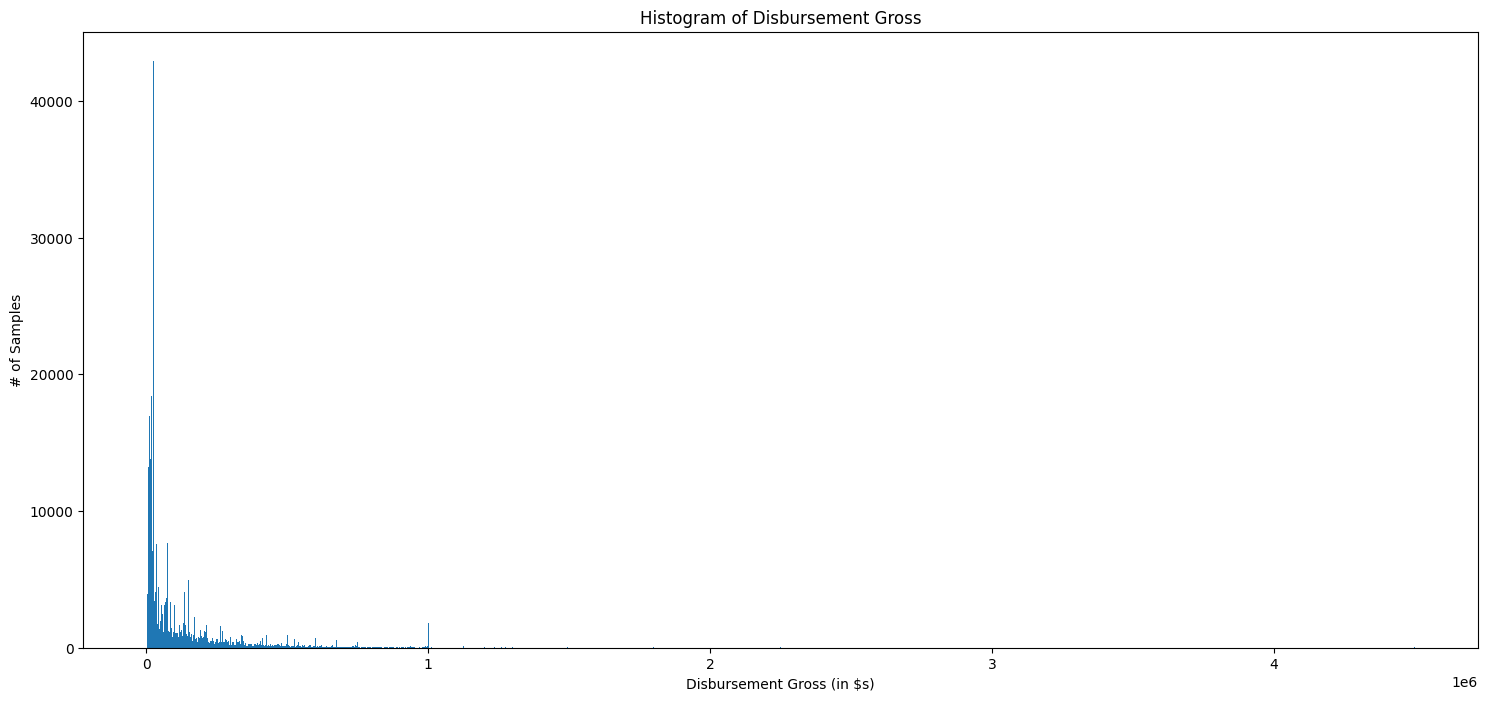

The Disbursement Gross ranges from $500.0 to $4500000.0.


In [12]:
histogram_visual(data['disbursement_gross'],
                 num_of_bins=3000,
                 plot_title="Histogram of Disbursement Gross",
                 x_label="Disbursement Gross (in $s)")

print(f"The Disbursement Gross ranges from " +
      f"${min(data['disbursement_gross'])} to" +
      f" ${max(data['disbursement_gross'])}.")

#### Dataset Visualization: Balance Remaining

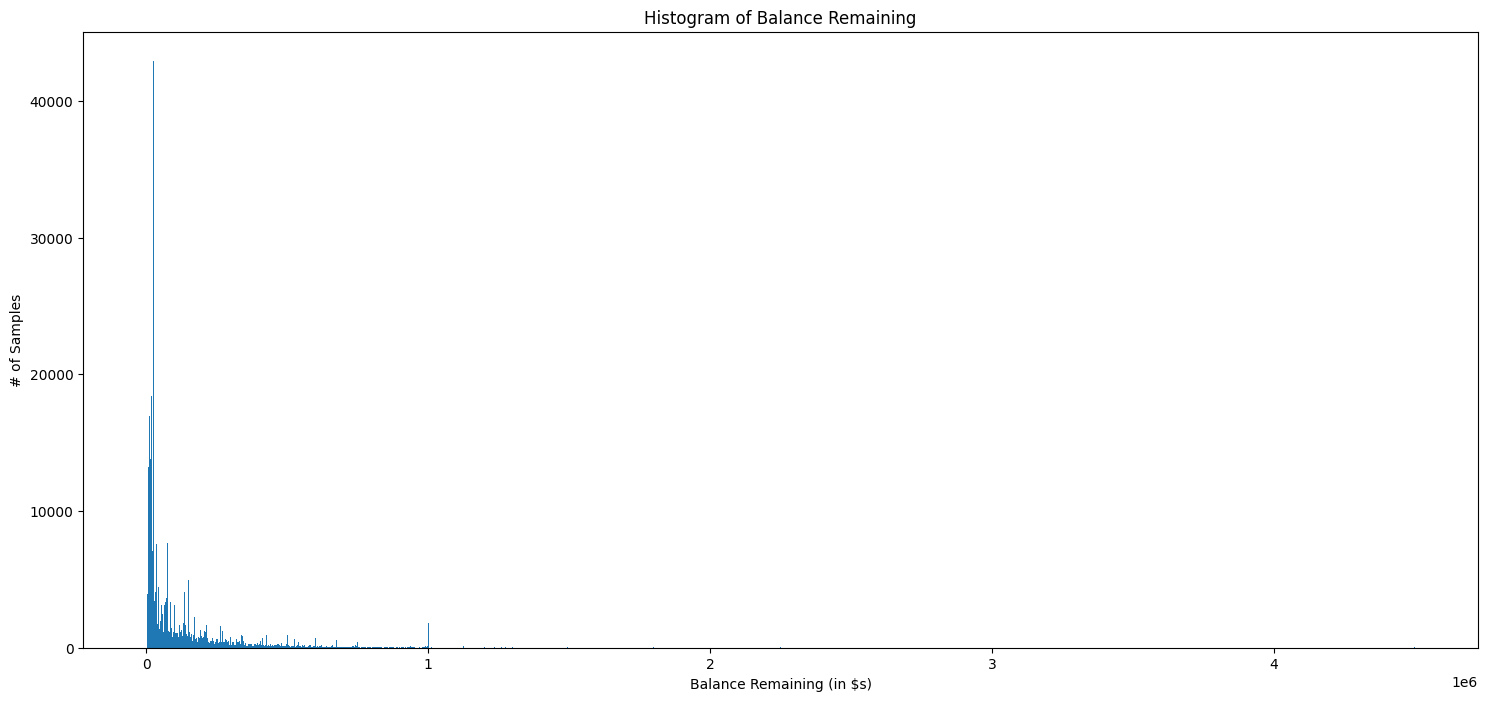

The Remaining Balance range from $500.0 to $4500000.0.


In [13]:
histogram_visual(data['balance_gross'],
                 num_of_bins=3000,
                 plot_title="Histogram of Balance Remaining",
                 x_label="Balance Remaining (in $s)")

print(f"The Remaining Balance range from " +
      f"${min(data['balance_gross'])} to" +
      f" ${max(data['balance_gross'])}.")

#### Dataset Visualization: Charged-Off Amount

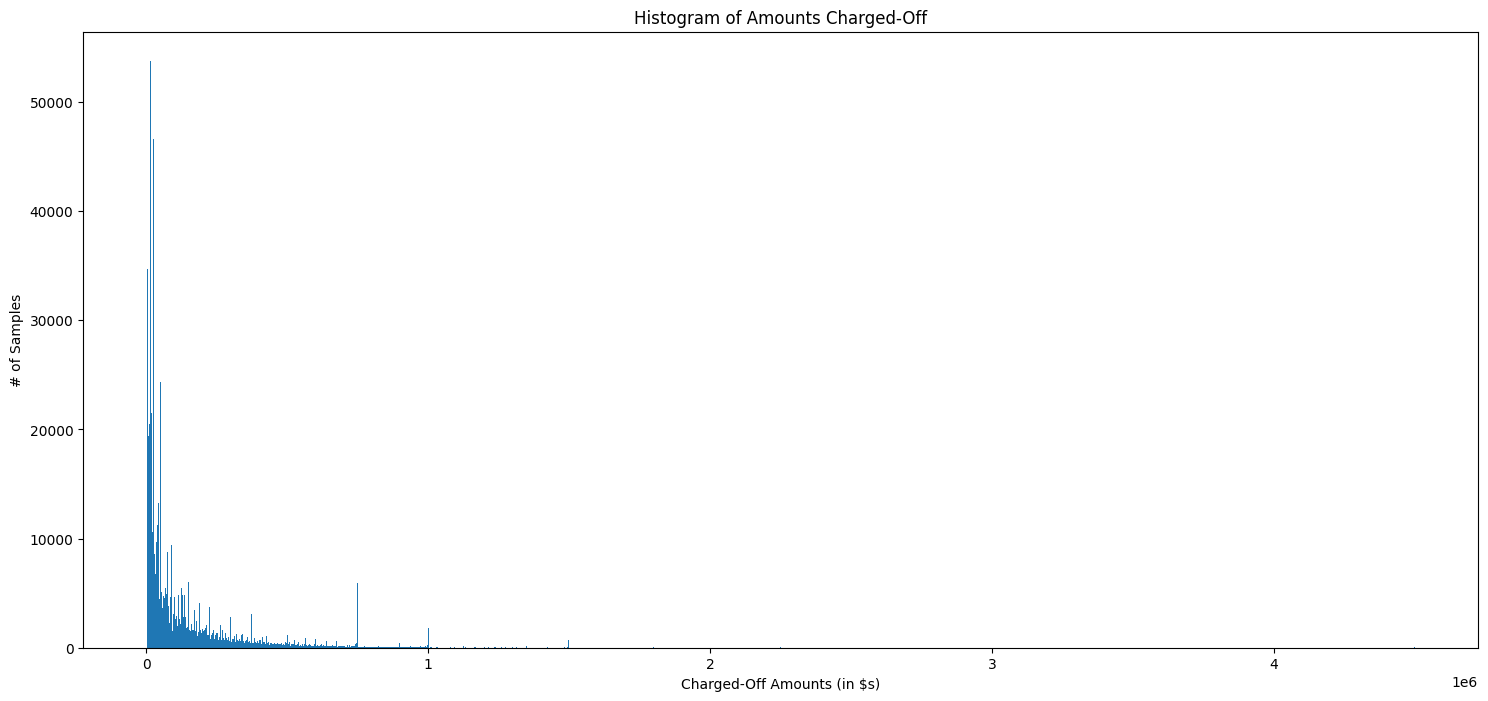

The amount charged off ranges from $500.0 to $4500000.0.


In [14]:
histogram_visual(data['charged_off_amt'],
                 num_of_bins=1500,
                 plot_title="Histogram of Amounts Charged-Off",
                 x_label="Charged-Off Amounts (in $s)")

print(f"The amount charged off ranges from" +
      f" ${min(data['charged_off_amt'])} to" +
      f" ${max(data['charged_off_amt'])}.")

#### Dataset Visualization: Amount That Bank Approved

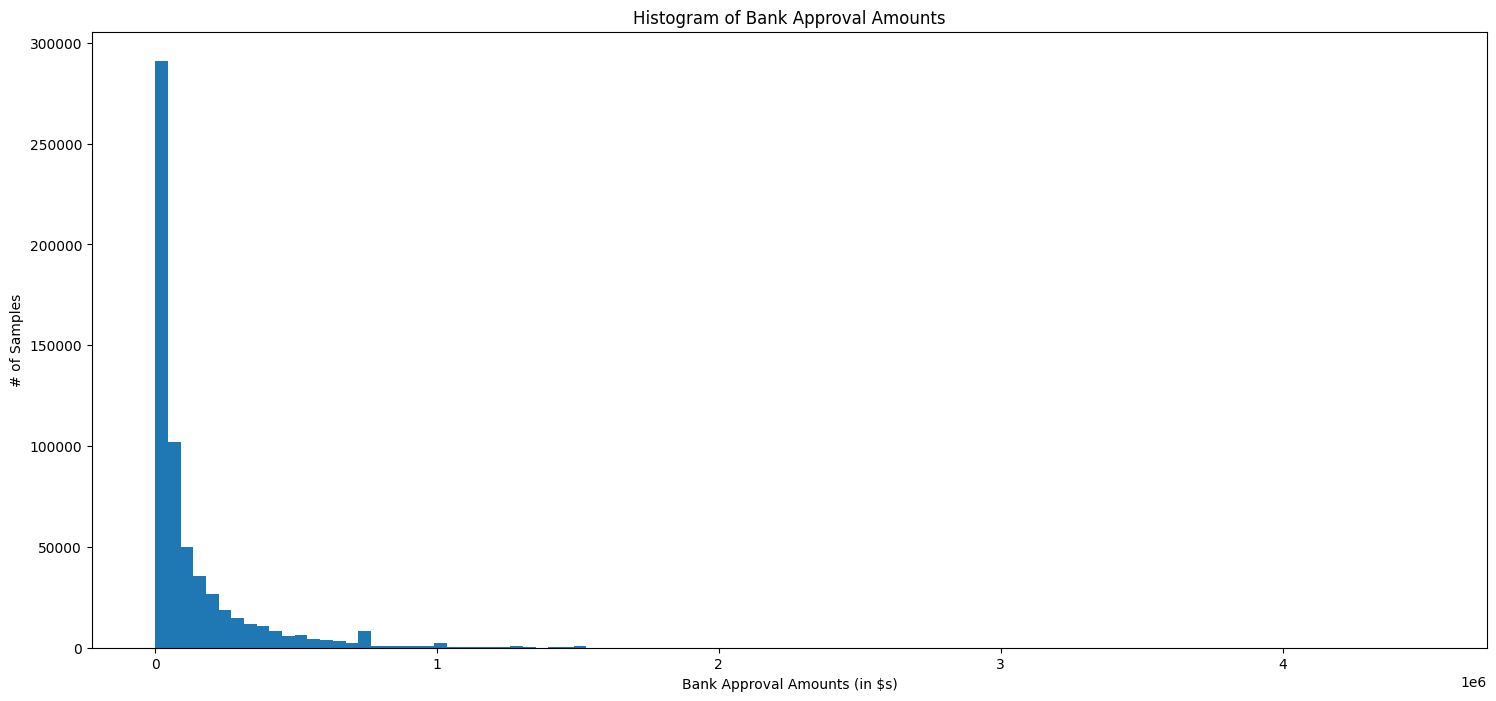

The amount that the bank approved ranged from $500.0 to $4500000.0.


In [15]:
histogram_visual(data['gr_appv'],
                 num_of_bins=100,
                 plot_title="Histogram of Bank Approval Amounts",
                 x_label="Bank Approval Amounts (in $s)")

print(f"The amount that the bank approved ranged" +
      f" from ${min(data['gr_appv'])}" +
      f" to ${max(data['gr_appv'])}.")

#### Dataset Visualization: Amount That SBA Approved

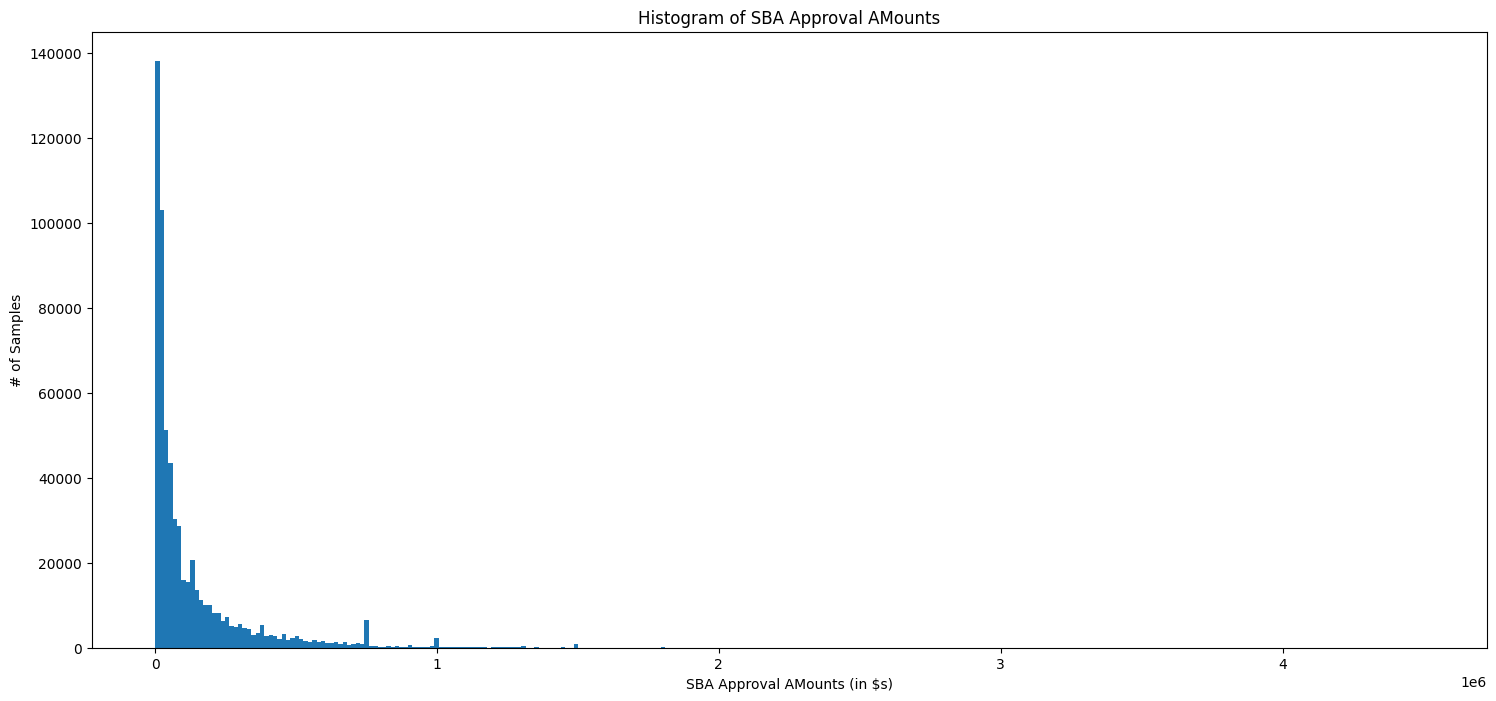

The amount that the SBA approved ranged from $500.0 to $4500000.0.


In [16]:
histogram_visual(data['sba_approval'],
                 num_of_bins=291,
                 plot_title="Histogram of SBA Approval AMounts",
                 x_label="SBA Approval AMounts (in $s)")

print(f"The amount that the SBA approved ranged" +
      f" from ${min(data['sba_approval'])}" +
      f" to ${max(data['sba_approval'])}.")

#### Create Function to Visualize Features (Barplot)

In [17]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   rotation: np.uint8 = 0,
                   annotations: bool = True,

                   ):
    """
    This function returns a histogram for a feature.

    Inputs:
    - feature_to_visualize: Feature to plot in the form
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    - rotation: Integer value of the rotation of x-tick
        values
    - annotations: If count of each unique value in
        feature is included in visualization

    Output:
    - A Bar Plot.
    """

    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(rotation) != np.uint8, \
        "The rotation value must be between 0 and 255."

    ax = feature_to_visualize.value_counts().plot.bar(
                                                      figsize=(12,8),
                                                      rot=rotation,
                                                      legend=False,
                                                      color=["lightgreen",
                                                             "blue",
                                                             "brown",
                                                             "lightblue",
                                                             "tan",
                                                             "yellow",
                                                             "orange",
                                                             "green",
                                                             "red",
                                                             "purple"]
                                                      )
    if annotations:
        ax.bar_label(ax.containers[0])

    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

#### Dataset Visualization: Approved in What Fiscal Year

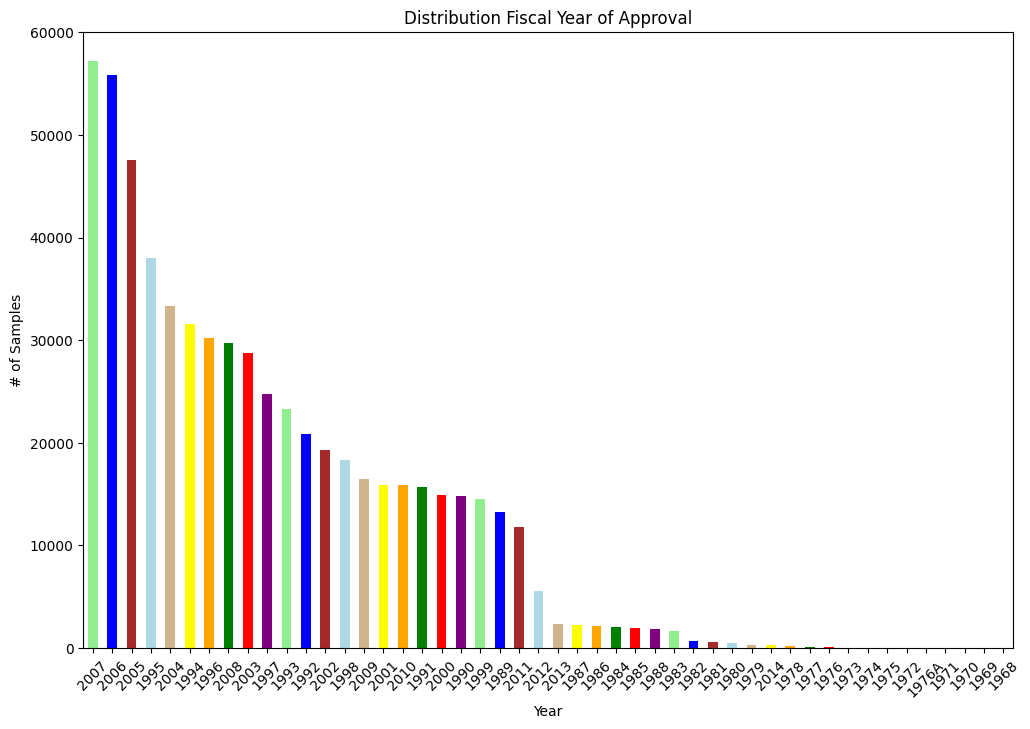

In [18]:
barplot_visual(data["approval_fy"],
               "Distribution Fiscal Year of Approval",
               "Year",
               "# of Samples",
               rotation=45,
               annotations=False
               )

#### Dataset Visualization: New or Existing Business?

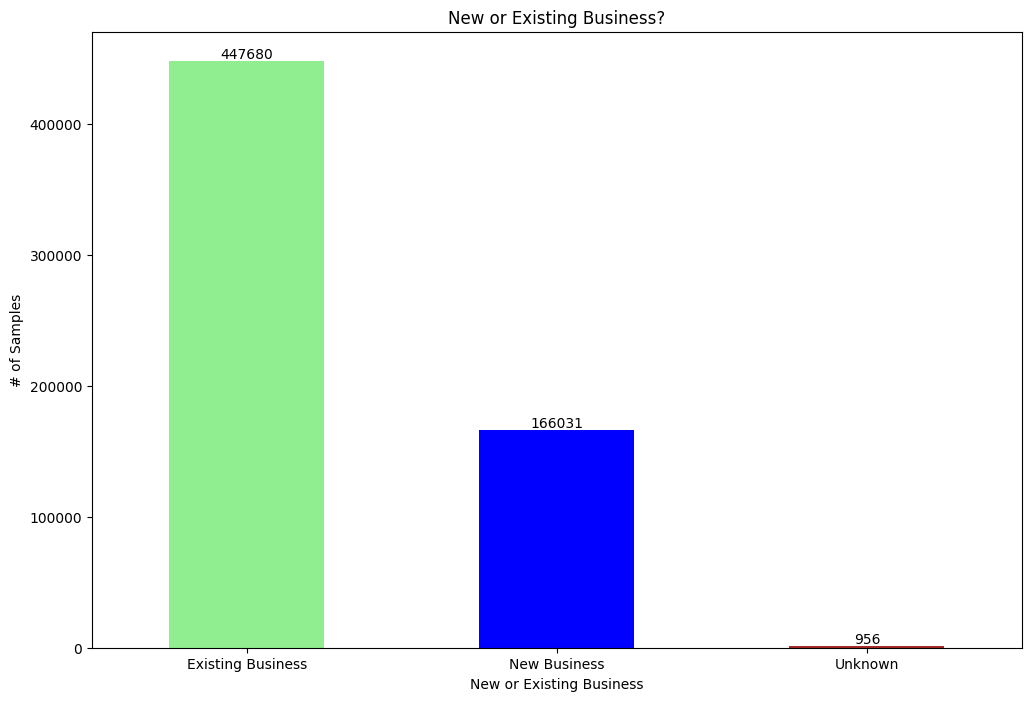

In [19]:
barplot_visual(data["new_exist"],
               "New or Existing Business?",
               "New or Existing Business",
               "# of Samples",
               )

#### Dataset Visualization: Urban, Rural, or Unknown

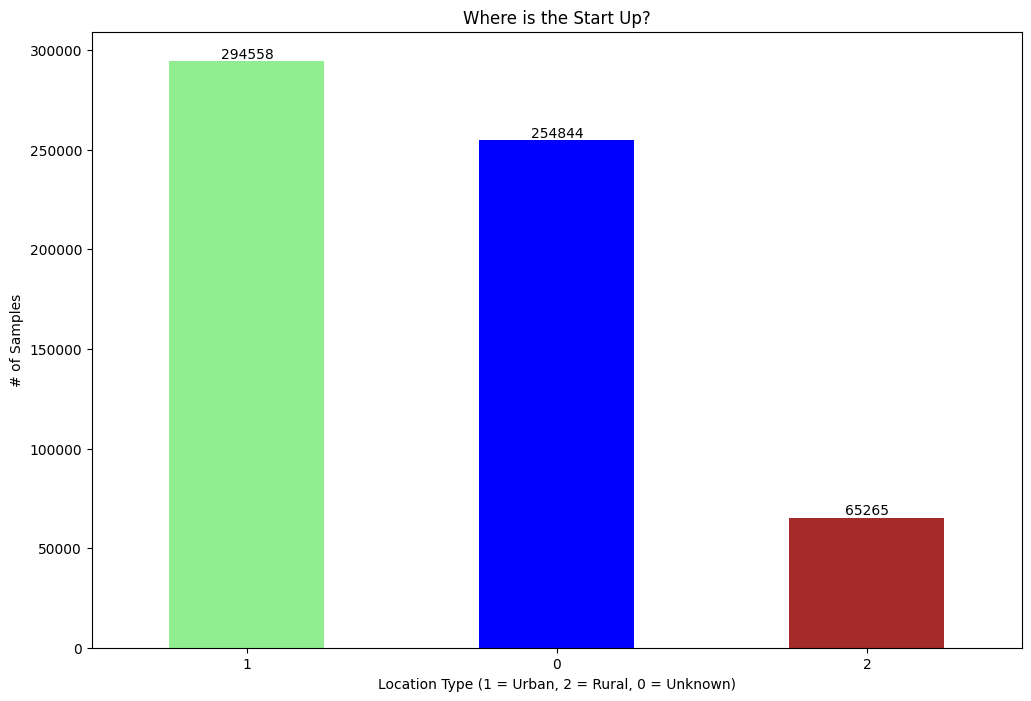

In [20]:
barplot_visual(data["urban_rural"],
               "Where is the Start Up?",
               "Location Type (1 = Urban, 2 = Rural, 0 = Unknown)",
               "# of Samples",
               )

#### Dataset Visualization: Revlving Line of Credit Status

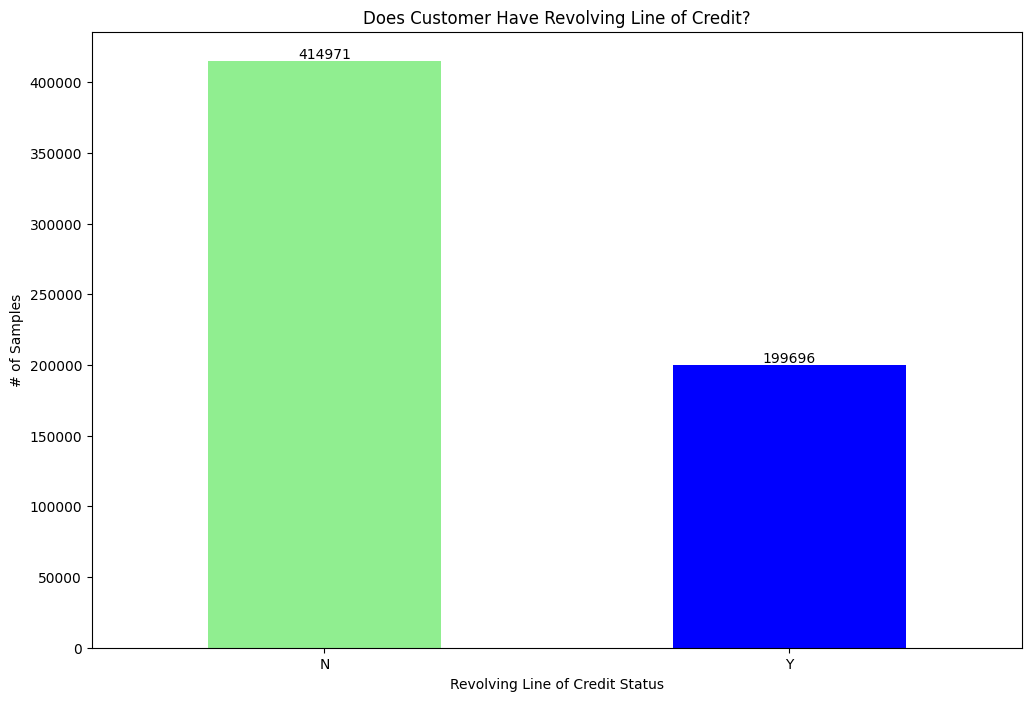

In [21]:
barplot_visual(data["rev_line_cr"],
               "Does Customer Have Revolving Line of Credit?",
               "Revolving Line of Credit Status",
               "# of Samples",
               )

#### Dataset Visualization: LowDoc Loan Program Status

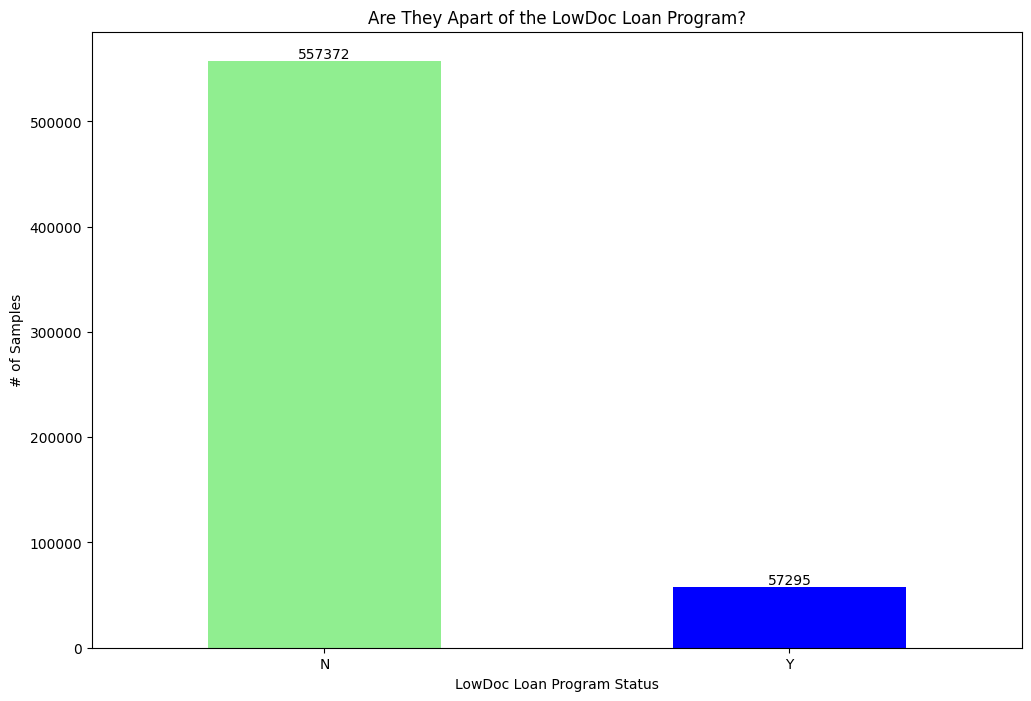

In [22]:
barplot_visual(data["low_doc"],
               "Are They Apart of the LowDoc Loan Program?",
               "LowDoc Loan Program Status",
               "# of Samples",
               )

#### Dataset Visualization: Loan Status

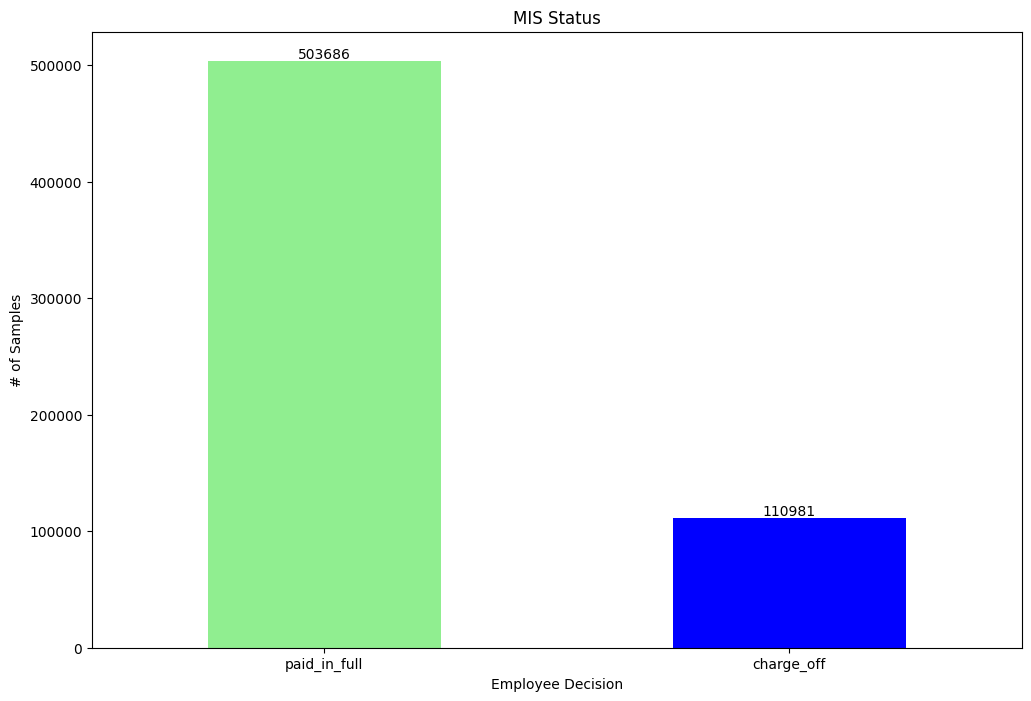

In [23]:
barplot_visual(data["mis_status"],
               "MIS Status",
               "Employee Decision",
               "# of Samples",
               )

### Exploratory Data Analysis & Preprocessing

#### Descriptive Statistics

In [24]:
data.describe(percentiles=[0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99], include='all')

,state,naics,approval_fy,term,num_of_emp,new_exist,created_job,retained_job,franchise_code,urban_rural,rev_line_cr,low_doc,disbursement_gross,balance_gross,mis_status,charged_off_amt,gr_appv,sba_approval
count,614667,614667.000000,614667,614667.000000,614667.000000,614667,614667.000000,614667.000000,614667.000000,614667,614667,614667,6.146670e+05,6.146670e+05,614667,6.146670e+05,6.146670e+05,6.146670e+05
unique,51,NaN,48,NaN,NaN,3,NaN,NaN,NaN,3,2,2,NaN,NaN,2,NaN,NaN,NaN
top,CA,NaN,2007,NaN,NaN,Existing Business,NaN,NaN,NaN,1,N,N,NaN,NaN,paid_in_full,NaN,NaN,NaN
freq,81323,NaN,57164,NaN,NaN,447680,NaN,NaN,NaN,294558,414971,557372,NaN,NaN,503686,NaN,NaN,NaN
mean,NaN,37.307977,NaN,105.095030,11.990649,NaN,0.263308,0.486548,0.042099,NaN,NaN,NaN,1.341954e+05,1.341954e+05,NaN,1.341954e+05,1.341954e+05,1.341954e+05
std,NaN,26.382146,NaN,75.538158,75.457243,NaN,0.440429,0.499819,0.200816,NaN,NaN,NaN,2.105699e+05,2.105699e+05,NaN,2.105699e+05,2.105699e+05,2.105699e+05
min,NaN,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,5.000000e+02,5.000000e+02,NaN,5.000000e+02,5.000000e+02,5.000000e+02
1%,NaN,0.000000,NaN,4.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,2.500000e+03,2.500000e+03,NaN,2.500000e+03,2.500000e+03,2.500000e+03
10%,NaN,0.000000,NaN,32.000000,1.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,9.000000e+03,9.000000e+03,NaN,9.000000e+03,9.000000e+03,9.000000e+03
25%,NaN,0.000000,NaN,60.000000,2.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.750000e+04,1.750000e+04,NaN,1.750000e+04,1.750000e+04,1.750000e+04


#### Finish Preprocessing Dataset

In [25]:
data['label'] = data['mis_status'].replace(
    {
        "charge_off": 0,
        "CHGOFF": 0,
        "paid_in_full": 1,
        "P I F": 1
    }
    ).astype(np.float32)

data = data.drop(columns=['mis_status'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614667 entries, 0 to 614666
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               614667 non-null  object 
 1   naics               614667 non-null  uint8  
 2   approval_fy         614667 non-null  object 
 3   term                614667 non-null  uint16 
 4   num_of_emp          614667 non-null  uint16 
 5   new_exist           614667 non-null  object 
 6   created_job         614667 non-null  int64  
 7   retained_job        614667 non-null  int64  
 8   franchise_code      614667 non-null  int64  
 9   urban_rural         614667 non-null  object 
 10  rev_line_cr         614667 non-null  object 
 11  low_doc             614667 non-null  object 
 12  disbursement_gross  614667 non-null  float32
 13  balance_gross       614667 non-null  float32
 14  charged_off_amt     614667 non-null  float32
 15  gr_appv             614667 non-nul

### Prepare Shared Pipeline Data & Stages/Steps

#### Split Dataset into Training & Testing Datasets

In [26]:
y = data['label']
X = data.drop(columns=['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f"Training Input Dataset Shape: {X_train.shape}")
print(f"Training Output Dataset Shape: {y_train.shape}")

print(f"Evaluation Input Dataset Shape: {X_test.shape}")
print(f"Evaluation Output Dataset Shape: {y_test.shape}")

Training Input Dataset Shape: (461000, 17)
Training Output Dataset Shape: (461000,)
Evaluation Input Dataset Shape: (153667, 17)
Evaluation Output Dataset Shape: (153667,)


#### Define Column Lists for Transformers (Pipeline Stages) & Transform to Integer Values

In [27]:
numerical_features = [
    "disbursement_gross",
    "balance_gross",
    "charged_off_amt",
    "gr_appv",
    "sba_approval"]

nominal_features = [x for x in data.columns
                if x not in numerical_features
                and x != 'label']

print(len(data.columns))
print(len(numerical_features + nominal_features + ['label']))

18
18


#### Remove Outliers

In [28]:
# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, features_to_remove):
    df = pd.DataFrame(df).copy()
    for feat in features_to_remove:
        x = df[feat]
        q1, q3 = x.quantile([0.25, 0.75])
        iqr = q3-q1
        ul = q3 + (iqr * 1.5)
        ll = q1 - (iqr * 1.5)
        neo_df = df[(df[feat] >= ll) | (df[feat] <= ul)]
    return neo_df

outlier_remover = FunctionTransformer(remove_outliers,
                                      kw_args={
                                          'features_to_remove': numerical_features
                                          }
                                      )

#### Create Numerical Pipeline

In [29]:
numerical_pipe = Pipeline(
    [
        (
            'outlier_remover',
            outlier_remover
        ),
        (
            'scaler',
            StandardScaler()
        )
    ]
)

#### Create Nominal Pipeline

In [30]:
nominal_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore',
                          dtype=np.float64)
        )
    ],
)

#### Combine Individual Column Pipelines Into Column Transformer

In [31]:
preprocessor = ColumnTransformer(
    [
        (
            'numerical_ct',
            numerical_pipe,
            numerical_features
        ),
        (
            'nominal_ct',
            nominal_pipe,
            nominal_features
        )
    ]
)

#### Metrics Evaluation Method

In [32]:
def metrics_evaluation(classifier_type,
                       y_test,
                       y_pred_cv):


    print("+-------------------------------------------------------------------------+")
    print(f"\tConfusion Matrix for {classifier_type}")
    print("+-------------------------------------------------------------------------+")

    cm = confusion_matrix(y_test,
                          y_pred_cv)

    display_cm = ConfusionMatrixDisplay(cm,
                                        display_labels=[
                                            "Denied",
                                            "Approved"
                                            ]
                                        )

    display_cm.plot()
    plt.show()

    print("+-----------------------------------------------------+")
    print(f"\tClassification Report for {classifier_type}")
    print("+-----------------------------------------------------+")

    print(classification_report(y_test,
                                y_pred_cv,
                                zero_division=0,
                                target_names=[
                                    "Denied",
                                    "Approved"]
                                )
          )

### Auto-Sklearn Classifier

#### Define Pipeline

In [33]:
def auto_sklearn_classifier():
    """
    This function creates the Auto-Sklearn classifier.
    """
    auto_sklearn_pipe = Pipeline(
        [
            (
                'preprocessor',
                preprocessor),
            (
                'truncated_svd',
                TruncatedSVD(random_state=42,
                             n_components=125)
            ),
            (
                'smote',
                SMOTE(random_state=42)
            ),
            (
                'auto_sklearn_clf',
                ASC(time_left_for_this_task=7200,
                    seed=42,
                    n_jobs=-1,
                    memory_limit=12088)
             ),
        ]
    )

    return auto_sklearn_pipe

#### Define Model

In [34]:
auto_sklearn_clf = auto_sklearn_classifier()

auto_sklearn_clf.named_steps

{'preprocessor': ColumnTransformer(transformers=[('numerical_ct',
                                  Pipeline(steps=[('outlier_remover',
                                                   FunctionTransformer(func=<function remove_outliers at 0x7f82329dc310>,
                                                                       kw_args={'features_to_remove': ['disbursement_gross',
                                                                                                       'balance_gross',
                                                                                                       'charged_off_amt',
                                                                                                       'gr_appv',
                                                                                                       'sba_approval']})),
                                                  ('scaler', StandardScaler())]),
                                  ['disbursement_gross',

#### Fit Dataset to Auto-Sklearn Classifier

In [35]:
auto_sklearn_clf_model = auto_sklearn_clf.fit(X_train, y_train)

#### Generate Predictions

In [36]:
predictions = auto_sklearn_clf_model.predict(X_test)

#### Metrics Evaluation

+-------------------------------------------------------------------------+
	Confusion Matrix for Auto Sklearn
+-------------------------------------------------------------------------+


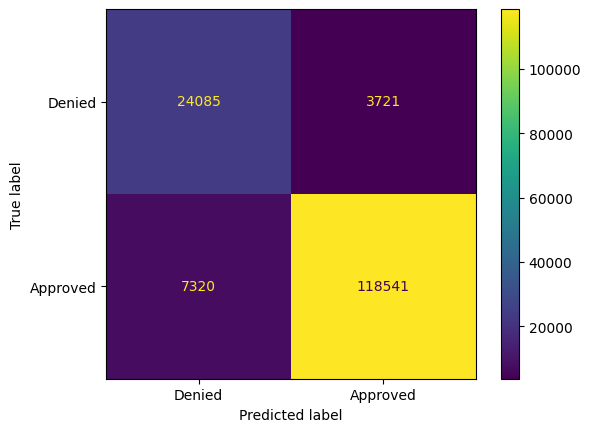

+-----------------------------------------------------+
	Classification Report for Auto Sklearn
+-----------------------------------------------------+
              precision    recall  f1-score   support

      Denied       0.77      0.87      0.81     27806
    Approved       0.97      0.94      0.96    125861

    accuracy                           0.93    153667
   macro avg       0.87      0.90      0.88    153667
weighted avg       0.93      0.93      0.93    153667



In [37]:
metrics_evaluation("Auto Sklearn",
                       y_test,
                       predictions)

### Notes & Other Takeaways From This Project
****
- While it is not the best results from an Auto-Sklearn Project, these are definitely excellent results nonetheless.
- This project took twice as long yet yielded the same results. What I learned from this is unless the dataset has a very large number of samples and/or features, stick with the default one hour training duration.

****

### Citation

- Auto-Sklearn
  > @inproceedings{feurer-neurips15a, title = {Efficient and Robust Automated Machine Learning}, author = {Feurer, Matthias and Klein, Aaron and Eggensperger, Katharina and Springenberg, Jost and Blum, Manuel and Hutter, Frank}, booktitle = {Advances in Neural Information Processing Systems 28 (2015)}, pages = {2962--2970}, year = {2015}}

  > @article{feurer-arxiv20a, title = {Auto-Sklearn 2.0: Hands-free AutoML via Meta-Learning}, author = {Feurer, Matthias and Eggensperger, Katharina and Falkner, Stefan and Lindauer, Marius and Hutter, Frank}, journal = {arXiv:2007.04074 [cs.LG]}, year = {2020},}